In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# !pip install seaborn
# !pip install folium
# !pip install geopy
# !pip install plotly

import seaborn as sns
import folium
import geopy
import plotly.express as px

  Using cached geopy-2.2.0-py3-none-any.whl (118 kB)
  Using cached geographiclib-1.52-py3-none-any.whl (38 kB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


# Nacteni dat

In [21]:
bikes_df = pd.read_pickle('data/bikes_df.pickle')
weather_df = pd.read_pickle('data/weather_df.pickle')
dist_df = pd.read_pickle('data/dist_table.pickle')

AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from 'C:\\Users\\START\\anaconda3\\envs\\edinburgh_bikes\\lib\\site-packages\\pandas\\_libs\\internals.cp39-win_amd64.pyd'>

In [3]:
dates_all = pd.date_range(bikes_df['started_at'].dt.round('D').min(), bikes_df['started_at'].dt.round('D').max())
dates_selection = pd.DatetimeIndex(np.unique(dates_all + pd.offsets.MonthBegin(0)))[::4]
dates_selection

DatetimeIndex(['2018-10-01', '2019-02-01', '2019-06-01', '2019-10-01',
               '2020-02-01', '2020-06-01', '2020-10-01', '2021-02-01',
               '2021-06-01'],
              dtype='datetime64[ns]', freq=None)

# Identifikujte aktivni a neaktivni stanice
- spocitame rozdil mezi uplne poslednim datem a datem posledni vypujcky na dane stanici

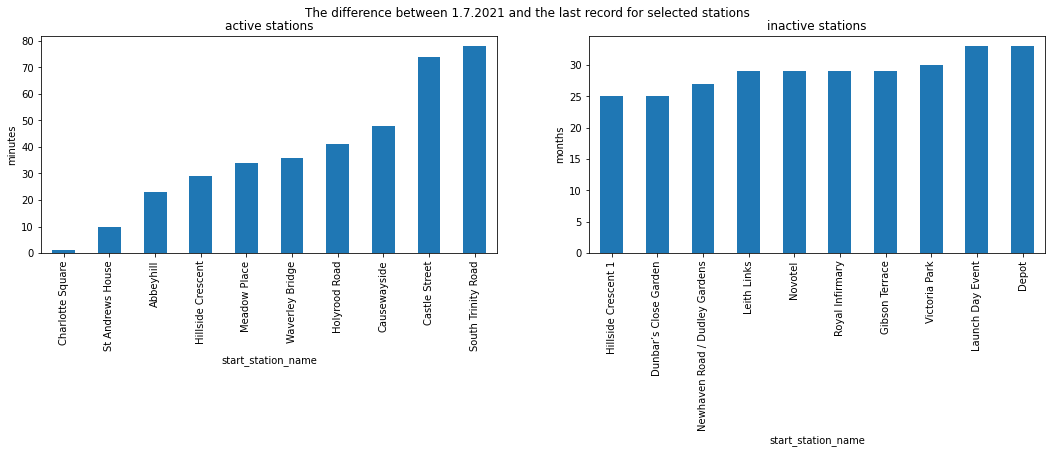

In [4]:
df = bikes_df[['start_station_name', 'started_at']]
last_start = pd.Timestamp('2021-07-01')
df = df.groupby('start_station_name').max()
df = df['started_at'].apply(lambda x: last_start-x)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,4))
fig.suptitle("The difference between 1.7.2021 and the last record for selected stations")
df.astype('timedelta64[m]').sort_values().iloc[:10].plot.bar(ax=ax1, ylabel='minutes', title='active stations')
df.astype('timedelta64[M]').sort_values().iloc[-10:].plot.bar(ax=ax2, ylabel='months', title='inactive stations')
plt.show()

# Identifikujte nejfrekventovanejsi stanice

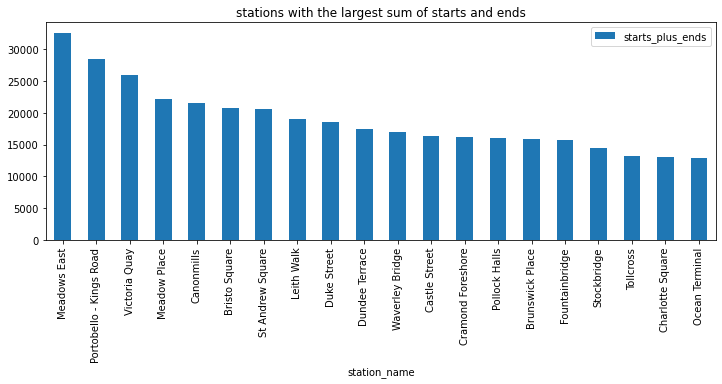

In [5]:
starts_df = pd.DataFrame(bikes_df[['start_station_name']].value_counts(), columns=['num_starts']).rename_axis('station_name')
ends_df = pd.DataFrame(bikes_df[['end_station_name']].value_counts(), columns=['num_ends']).rename_axis('station_name')

starts_ends_df = starts_df.join(ends_df, how='outer').fillna(0)
df = (starts_ends_df['num_starts'] + starts_ends_df['num_ends']).sort_values(ascending=False).reset_index().rename(columns={0: 'starts_plus_ends'})

df.iloc[:20].set_index('station_name').plot.bar(figsize=(12,4), title='stations with the largest sum of starts and ends')
plt.show()

# Identifikujte stanice, na kterych se kola hromadi, a kde potencialne chybi

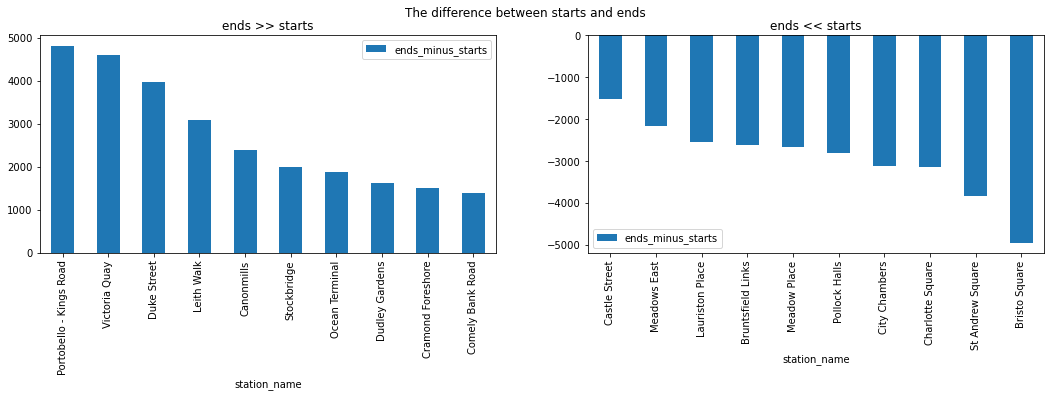

In [6]:
df = (starts_ends_df['num_ends'] - starts_ends_df['num_starts']).sort_values(ascending=False).reset_index().rename(columns={0: 'ends_minus_starts'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,4))
fig.suptitle('The difference between starts and ends')
df.iloc[:10].set_index('station_name').plot.bar(ax=ax1, title='ends >> starts')
df.iloc[-10:].set_index('station_name').plot.bar(ax=ax2, title='ends << starts')
plt.show()

# Spocitejte vzdalenosti mezi jednotlivymi stanicemi

In [7]:
df = bikes_df[['start_station_name', 'start_station_latitude', 'start_station_longitude']].round(4).drop_duplicates()
df.columns = ['station_name', 'lat', 'lon']
df = df.set_index('station_name')

In [8]:
from geopy.distance import geodesic
from itertools import combinations, product

@np.vectorize
def geodesic_vec(lat1, lon1, lat2, lon2):
    rs = geodesic( (lat1, lon1), (lat2, lon2) ).kilometers
    return rs

coords = np.array(list(product(df[['lat', 'lon']].values, df[['lat', 'lon']].values)))
coords = coords.reshape(coords.shape[0], 4)
distances = geodesic_vec(coords[:, 0], coords[:, 1], coords[:, 2], coords[:, 3])

In [9]:
combos = list(product(df.index, df.index))
index = pd.Index(data=combos, names=['station1', 'station2'])
dist_df = pd.DataFrame(distances, index=index, columns=['distance'])
dist_table = dist_df.reset_index().pivot_table(values='distance', index='station1', columns='station2')
dist_table.head()

C:\Users\START\AppData\Local\Temp\ipykernel_25728\639082438.py:2: FutureWarning: Passing keywords other than 'data', 'dtype', 'copy', 'name', 'tupleize_cols' is deprecated and will raise TypeError in a future version.  Use the specific Index subclass directly instead
  index = pd.Index(data=combos, names=['station1', 'station2'])


station2,Abbeyhill,Balgreen,Balgreen Road,Belford Road,Boroughmuir,Borrowman Square,Bristo Square,Brunswick Place,Brunswick Place - Virtual,Bruntsfield,...,Waverley Bridge,Waverley Court,Waverley Station,West Crosscauseway,West Newington Place,Wester Coates Terrace,Western General,Western General Hospital,Whitehouse Loan,Whitehouse Road
station1,,,,,,,,,,,,,,,,,,,,,
Abbeyhill,0.000000,5.258848,5.252985,3.385797,3.174517,13.420630,1.469916,0.839577,0.839577,2.929583,...,1.278361,0.844855,0.998625,1.495481,1.939890,3.870752,3.896154,3.929970,2.822252,8.392738
Balgreen,5.258848,0.000000,0.006249,2.141696,2.247373,9.481634,3.970111,5.023331,5.023331,2.806057,...,3.982575,4.422161,4.262280,4.173208,4.512576,1.426031,2.970411,2.917734,3.069601,4.253832
Balgreen Road,5.252985,0.006249,0.000000,2.137125,2.241136,9.486995,3.963985,5.017878,5.017878,2.799822,...,3.976739,4.416247,4.256447,4.167015,4.506328,1.420710,2.967999,2.915373,3.063380,4.258871
Belford Road,3.385797,2.141696,2.137125,0.000000,1.486888,10.284742,2.421319,2.986282,2.986282,2.056816,...,2.152804,2.617720,2.412252,2.723417,3.319833,0.795223,1.347076,1.325602,2.295019,5.107716
Boroughmuir,3.174517,2.247373,2.241136,1.486888,0.000000,11.407744,1.771501,3.155150,3.155150,0.643108,...,1.959282,2.333205,2.225734,1.938831,2.278258,1.196467,2.825447,2.807428,0.915971,6.152562


In [22]:
dist_table.to_pickle('data/dist_table.pickle')

<AxesSubplot:xlabel='station2', ylabel='station1'>

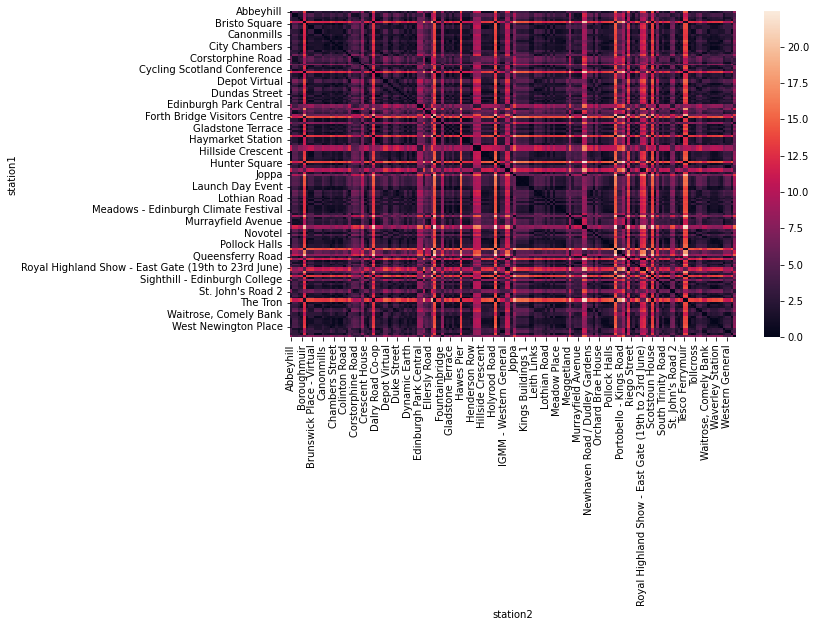

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(dist_table, ax=ax)

# Jak dlouho trva jedna vypujcka? Najdete odlehle hodnoty, zobrazte historam

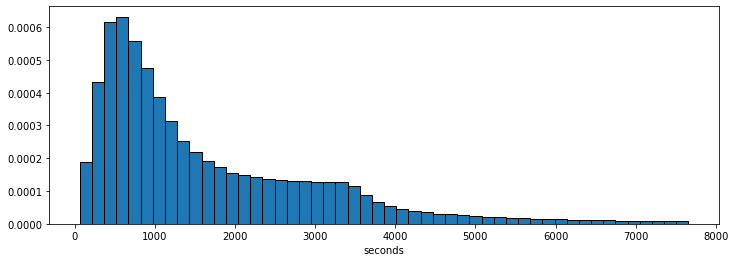

In [12]:
durations = bikes_df[['duration']]
q = np.quantile(durations.values, 0.975)

fig, ax = plt.subplots(figsize=(12,4))
ax.hist(durations[durations<q], bins=50, density=True, edgecolor='k')
ax.set_xlabel('seconds')
plt.show()

# Zobrazte vyvoj poptavky po kolech v case

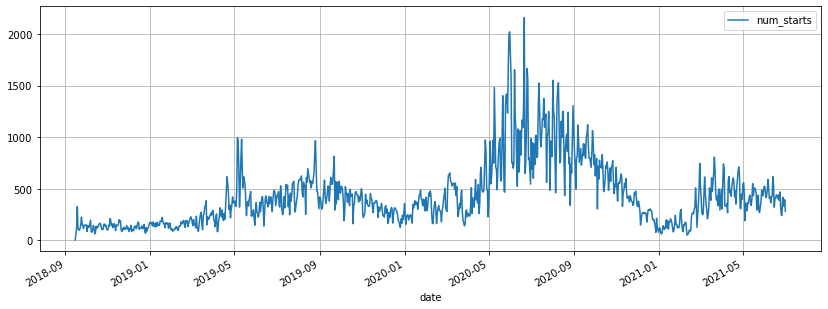

In [13]:
df = pd.DataFrame(bikes_df['started_at'].dt.round('D').value_counts()).sort_index().rename(columns={'started_at': 'num_starts'}).rename_axis('date')
df.plot(figsize=(14,5), grid=True)
plt.show()

In [14]:
import datetime as dt
dt.datetime.date(df.index.min())

datetime.date(2018, 9, 15)

# Zjistěte vliv počasí na poptávku po kolech

In [15]:
from warnings import filterwarnings; filterwarnings('ignore')

bdf = bikes_df['started_at'].dt.round('H').value_counts().sort_index().reset_index()
bdf.columns = ['time', 'num_rentals']
bdf = (bdf.assign(date=bdf['time'].dt.round('D'), hh=bdf['time'].dt.hour)
       .set_index(['date', 'hh'])
       .sort_values('time')
       .drop('time', axis=1)
       )

wdf = weather_df[['date', 'time', 'temp', 'wind', 'rain']]
wdf['date'] = pd.to_datetime(wdf['date'])
wdf['time'] = wdf['time'].apply(lambda x: x.split(':')[0]).apply(lambda x: int(x[1:]) if str(x)[0]=='0' else x)
for col in ['temp', 'wind', 'rain']:
    wdf[col] = wdf[col].apply(lambda x: x.split(' ')[0])

wdf['hh'] = wdf['time'].astype(int)
wdf = wdf.set_index(['date', 'hh']).drop('time', axis=1).rename(columns={'temp': 'temperature'})

bwdf = bdf.join(wdf).dropna().astype(float)

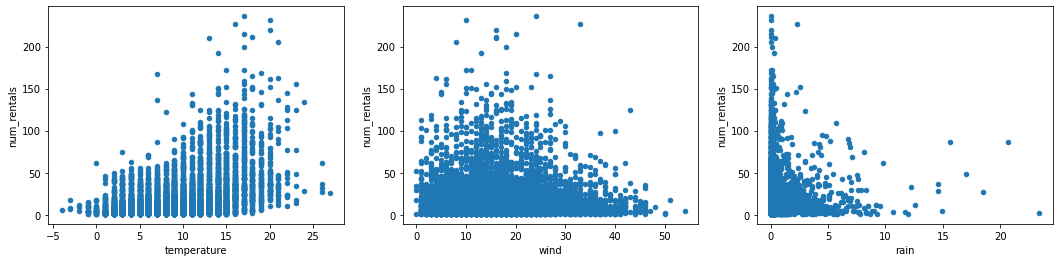

In [16]:
fig, axes = plt.subplots(1,3,figsize=(18,4))

for ax, col in zip(axes, ['temperature', 'wind', 'rain']):
    bwdf.plot.scatter(col, 'num_rentals', ax=ax)

In [17]:
bwdf

num_rentals  temperature  wind  rain
date       hh                                      
2018-09-15 9           2.0         10.0  16.0   0.0
2018-09-16 12          6.0         14.0  32.0   0.0
2018-09-17 9           5.0         13.0  16.0   0.0
2018-09-18 0           1.0         15.0  19.0   0.0
           3           1.0         14.0  14.0   0.0
...                    ...          ...   ...   ...
2020-10-31 12         65.0         14.0  24.0   0.4
           12         33.0         14.0  24.0   0.4
           15         62.0         10.0  42.0   0.5
           18         59.0          9.0  38.0   0.0
           21         36.0          8.0  36.0   0.1

[5735 rows x 4 columns]

# Bunus: mapa satanic

In [20]:
df = bikes_df.loc[bikes_df.started_at.dt.year==2021, ['start_station_name', 'start_station_latitude', 'start_station_longitude']].round(4).drop_duplicates()
df.columns = ['station_name', 'lat', 'lon']
df = df.set_index('station_name')

m = folium.Map(location=df.mean(), zoom_start=12)
for idx, row in df.reset_index().iterrows():
    folium.Marker(row[['lat', 'lon']].values.tolist(), 
                  tooltip=folium.Tooltip(row['station_name']),
                  icon=folium.Icon(icon='bicycle', prefix='fa'),
                  # popup=folium.Popup(row['station_name'], max_width=500)
                 ).add_to(m)
m